# 在二维平面上渲染三维对象

In [11]:
try:
    import sys
    # 将项目根路径加入系统路径集合, 即可以引入相关的包
    sys.path.append("../..")
finally:
    pass

# 引入所需的包
import random
from common import Vector, Vector2D, Vector3D, Face
from common.vector import scale, length, subtract, dot, cross
from common.vector_draw import (
    Color,
    draw2d, Points2D, Polygon2D,
    draw3d, Points3D, Arrow3D, Polygon3D
)
from typing import Iterable, List


**目标:** 渲染一个简单的三维形状，称为八面体. 立方体有 `6` 个面, 所有面都是正方形; 而八面体有 `8` 个面, 所有面都是三角形. 可以把八面体看成两个互相叠加的四边金字塔

![X](../assets/octahedron.png)

如果它是一个实体, 我们就看不到对面的边了, 只能看到 `8` 个三角形面中的 `4` 个

![X](../assets/octahedron-front.png)

渲染八面体归根结底就是确定我们需要显示的 `4` 个三角形, 并进行适当的着色

## 1. 使用向量定义三维对象


八面体是一个简单的例子, 因为它只有 `6` 个角 (顶点). 我们可以为其设置简单的坐标: `(1, 0, 0)`, `(0, 1, 0)` 和 `(0, 0, 1)` 以及与它们相反的三个向量

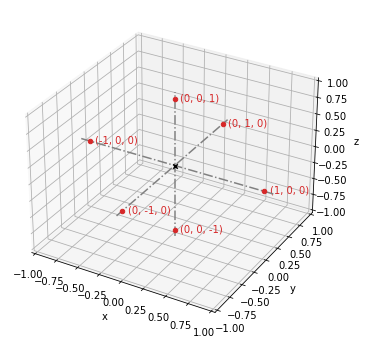

In [12]:
# 定义 6 个顶点的坐标
coords = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (-1, 0, 0),
    (0, -1, 0),
    (0, 0, -1),
]

# 绘制 8 边形的 6 个顶点
draw3d(
    Points3D(*coords, color=Color.red),
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1),
)


将相关顶点连接后, 即可得到 `8` 面体的边

In [13]:
def vertices(faces: Iterable[Iterable[Vector]]) -> Vector:
    """
    从定义的向量集合中获取不重复的向量点坐标

    Args:
        faces (Iterable[Iterable[Vector]]): 向量集合

    Returns:
        Vector: 向量点坐标
    """
    return list(
        set(vertex for face in faces for vertex in face)
    )

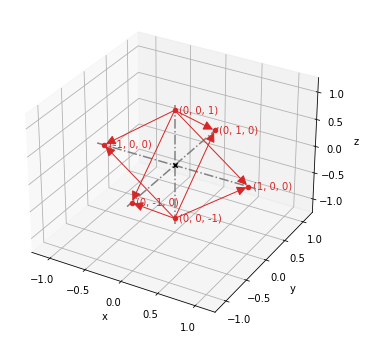

In [14]:
# 定义 8 边形的 8 条边
sides = [
    [(0, 0, 1), (-1, 0, 0)],
    [(0, 0, 1), (0, 1, 0)],
    [(0, 0, 1), (1, 0, 0)],
    [(0, 0, 1), (0, -1, 0)],
    [(0, 0, -1), (-1, 0, 0)],
    [(0, 0, -1), (0, 1, 0)],
    [(0, 0, -1), (1, 0, 0)],
    [(0, 0, -1), (0, -1, 0)],
]

# 绘制图形
draw3d(
    Points3D(*vertices(sides), color=Color.red),  # 绘制 8 条边对应的 6 个顶点
    *[Arrow3D(s[1], s[0], color=Color.red) for s in sides],  # 绘制 8 条边
)


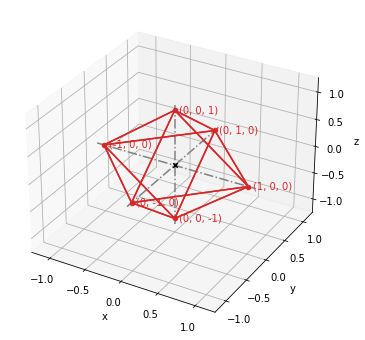

In [15]:
#  定义 8 边形对应的 8 个三角形面
faces = [
    [(1, 0, 0), (0, 1, 0), (0, 0, 1)],
    [(1, 0, 0), (0, 0, -1), (0, 1, 0)],
    [(1, 0, 0), (0, 0, 1), (0, -1, 0)],
    [(1, 0, 0), (0, -1, 0), (0, 0, -1)],
    [(-1, 0, 0), (0, 0, 1), (0, 1, 0)],
    [(-1, 0, 0), (0, 1, 0), (0, 0, -1)],
    [(-1, 0, 0), (0, -1, 0), (0, 0, 1)],
    [(-1, 0, 0), (0, 0, -1), (0, -1, 0)],
]

# 计算 6 个顶点
draw3d(
    Points3D(*vertices(faces), color=Color.red),  # 绘制 8 条边对应的 6 个顶点
    *[Polygon3D(*vs, color=Color.red) for vs in faces],  # 绘制 8 个面
)


## 2. 二维投影

**知识:** 要把三维点变成二维点, 必须选择我们的三维观察方向

一旦从视角上确定了定义“上”和“右”的两个三维向量, 就可以将任意三维向量投射到它们上面, 得到两个分量而不是三个分量

In [16]:
def component(v: Vector3D, direction: Vector3D) -> float:
    """
    利用点积提取三维向量在给定方向上坐标轴的分量

    Args:
        v (Vector3D): 三维向量
        direction (Vector3D): 三维向量的方向, 为仅有一个维度为 `1` 的三维向量

    Returns:
        float: 三维向量在二维坐标指定方向的分量
    """
    # 方向点积是一个只有一个维度为 1
    # 向量和方向的点积除以方向向量的长度得到三维坐标在二维坐标轴的一个分量
    return dot(v, direction) / length(direction)


通过对两个方向硬编码 (在本例中是 $(1, 0, 0)$ 和 $(0, 1, 0)$), 可以建立一种从三个坐标向下投影到两个坐标的方法

类似于把三维向量“压平”到二维平面上. 删除 $z$ 分量会使向量的深度消失

![X](../assets/projection.png)

In [17]:
def vector_to_2d(v: Vector3D) -> Vector2D:
    """
    接收一个三维向量或三个数组成的元组, 并返回一个二维向量或两个数组成的元组

    Args:
        v (Vector3D): 三维向量

    Returns:
        Vector2D: 三维向量在二维坐标的投影
    """
    # 将三维坐标转化为二维坐标 x 和 y 轴的分量, 即组成三维坐标在二维坐标的投影
    return (component(v, (1, 0, 0)), component(v, (0, 1, 0)))


 由此, 通过将三维顶点坐标转为二维坐标, 即可以将三维的一个平面转换成二维的投影

In [18]:
def face_to_2d(face: Face) -> List[Vector2D]:
    """
    将一组三维顶点坐标转换为二维坐标

    Args:
        face (Face): 一组三维顶点坐标, 表示一个三维的面

    Returns:
        List[Vector2D]: 三维顶点坐标在二维坐标系的投影
    """
    # 将一组三维坐标进行二维转换, 即得到这一组三维坐标围成的面在二维坐标的投影s
    return [vector_to_2d(vertex) for vertex in face]


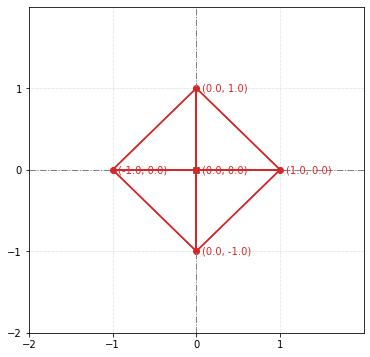

In [19]:
# 将一组三维顶点坐标转为二维投影
faces_2d = [face_to_2d(face) for face in faces]

# 绘制三维坐标顶点组成的面在二维坐标的投影
draw2d(
    Points2D(*vertices(faces_2d), color=Color.red),
    *[Polygon2D(*vs, color=Color.red) for vs in faces_2d],
)


## 3. 确定面的朝向和阴影

**知识:** 给定法线向量 (垂直于每个面的向量) 和一个指向光源的向量, 它们的点积就说明了其对齐程度

由于只考虑方向, 光源向量可以选择长度为 `1` 的向量, 则:
- 如果该面完全朝向光源, 则点积介于 `0` 和 `1` 之间;
- 如果该面与光源的角度超过 `90°`, 则将完全不能被照亮;

In [20]:
def unit(v: Vector) -> Vector:
    """
    返回和输入向量方向相同, 但长度为 `1` 的向量

    Args:
        v (Vector): 输入向量

    Returns:
        Vector: 和输入向量方向一致, 但长度为 `1` 的向量
    """
    return scale(v, 1.0 / length(v))


def normal(face: Face) -> Vector3D:
    """
    计算一个三维面的法线 (垂直面的向量)

    Args:
        face (Face): 三个三维向量集合, 表示一个三维平面

    Returns:
        Vector3D: 垂直三维平面的法向量
    """
    return cross(subtract(face[1], face[0]), subtract(face[2], face[0]))


In [21]:
def render(faces: Iterable[Face], light=(1, 2, 3), color_map=None, lines=None) -> None:
    polygons = []
    
    for face in faces:
        unit_normal = unit(normal(face))
        
        if unit_normal[2] > 0:
            c = color_map(1 - dot(unit_normal), unit(light))

            p = Polygon2D(*face_to_2d(face))